<a href="https://colab.research.google.com/github/ancastillar/Transformers-Create-your-own-poem-/blob/main/Transformers_Create_your_own_poem!_with_AI_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries

In [1]:
!pip install aitextgen
!pip install flask-ngrok
!pip install flask==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np


#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set(rc = {'figure.figsize':(35,10)})
sns.set_palette("Paired")
sns.set_style("white")
from flask import Flask, request, render_template
from flask_ngrok import run_with_ngrok

##########Models
from aitextgen import aitextgen
import torch
import sys
import os
import random
import time 
import datetime

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print("Available GPUs: ", torch.cuda.get_device_name(current_device))
    print()

!nvidia-smi

import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, get_linear_schedule_with_warmup, GPT2TokenizerFast
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

Available GPUs:  Tesla T4

Thu Jun 30 00:49:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                             

## Import Data

In [3]:
col_poem = "stanza_text"

#------------------------------------------------

df_poems = pd.read_csv("/content/drive/MyDrive/proyecto_NLP/data/poe_poems_stanzas.csv")
df_poems = df_poems[df_poems[col_poem].notna()]
print("Dimension of datase:", df_poems.shape)

Dimension of datase: (215, 2)


##📜 Global Functions

In [4]:
class PoemDataset(Dataset):
    
    def __init__(self, data, tokenizer, max_length, gpt2_type='gpt2'):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []
        
        for i in data:
            encodings_dict = tokenizer('<BOS>' + i + '<EOS>',
                                     truncation=True,
                                     max_length=max_length,
                                     padding='max_length'
                                    )

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        
        return self.input_ids[idx], self.attn_masks[idx]



#----------------------------------------------------------------------------------------------------------------------------------------------------

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))
    

#-----------------------------------------------------------------------------------------------------------------------------------------------------

def train_val_split(split, dataset):

    train_size = int(split * len(dataset))
    val_size = len(dataset) - train_size
    return train_size, val_size



In [5]:
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------

RANDOM_SEED = 73
BATCH_SIZE = 2
epochs = 20
MAX_LEN = 1024
home_directory = "/content/drive/MyDrive/proyecto_NLP/models"
###################################################################################################################################################################################################

pretrained_weights = "gpt2-large" ## as over 1.5 billion parameters
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_weights)

special_tokens_dict = {'bos_token': '<BOS>', 'eos_token': '<EOS>', 'pad_token': '<PAD>'}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

loading file https://huggingface.co/gpt2-large/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/79f5e05af067df502528a0d902e82c24c3f1df9ae570c91fcc38e1f3c0af4c45.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f
loading file https://huggingface.co/gpt2-large/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/7f7bf8a7802a708af08a812bfbdec9335f2c30f761ec14a8cd17b0d61c818876.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/gpt2-large/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/gpt2-large/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/gpt2-large/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/gpt2-large/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/d82fb41558a2cc40bb6e10a57bbfbd9ff2f3c6614072f05afdfa8f4

# 🕸 Text Generation - GPT-2

In [6]:
combined_poems = df_poems.groupby(['title'])['stanza_text'].transform(lambda x: ' /n /n '.join(x)).drop_duplicates().reset_index(drop=True)

In [7]:
max_poem_length = max([len(tokenizer.encode(poem)) for poem in combined_poems])
min_poem_length = min([len(tokenizer.encode(poem)) for poem in combined_poems])
print('Longest Poem:', max_poem_length, 'tokens long.')
print('Shortest Poem:', min_poem_length, 'tokens long.')

Token indices sequence length is longer than the specified maximum sequence length for this model (1753 > 1024). Running this sequence through the model will result in indexing errors


Longest Poem: 6465 tokens long.
Shortest Poem: 55 tokens long.


In [8]:
stanza_length = [len(tokenizer.encode(stanza)) for stanza in df_poems[col_poem].values]
max_stanza_length = max(stanza_length)
min_stanza_length = min(stanza_length)
print('Number of stanzas longer than max length (1024 tokens): ', sum([st_len > MAX_LEN for st_len in stanza_length])) 
print('Longest Stanza:', max_stanza_length, 'tokens long.')
print('Shortest Stanza:', min_stanza_length, 'tokens long.')

Number of stanzas longer than max length (1024 tokens):  1
Longest Stanza: 1948 tokens long.
Shortest Stanza: 15 tokens long.


In [9]:
poem_dataset = PoemDataset(df_poems[col_poem].values, tokenizer, max_length=MAX_LEN)

##🐝 Train-Test Split

In [10]:
#------------------------------------------------------------------------------------------------------------------------------------

poem_train_size, poem_val_size = train_val_split(0.8, poem_dataset)

# random split imported from troch.utils
poem_train_dataset, poem_val_dataset = random_split(poem_dataset, [poem_train_size, poem_val_size])


#-------------------------------------------------------Random Seeds

torch.cuda.manual_seed_all(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

##🐝 Data Loaders

In [11]:
poem_train_dataloader = DataLoader(poem_train_dataset,
                              sampler=RandomSampler(poem_train_dataset),
                              batch_size=BATCH_SIZE)

poem_val_dataloader = DataLoader(poem_val_dataset,
                            sampler=SequentialSampler(poem_val_dataset),
                            batch_size=BATCH_SIZE)

#-------------------------------------------------------------------------------------------------------------

# helper function for logging time
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

# hyperparameters
learning_rate = 1e-4
eps = 1e-8
warmup_steps = 20
# this produces sample output every 100 steps
sample_every = 10

# create text generation seed prompt
device = torch.device('cuda')

prompt = "<BOS>"
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

##🚀 FineTunning: Training

In [12]:
configuration = GPT2Config(vocab_size=len(tokenizer), n_positions=MAX_LEN).from_pretrained("gpt2", output_hidden_states=True)

poem_model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

poem_model.resize_token_embeddings(len(tokenizer))

poem_model.cuda()

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(poem_model.parameters(), lr=learning_rate, eps=eps)

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(poem_train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

#------------------------------------------------------------------------------------------------------------------

loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "output_hidden_states": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params

In [ ]:
total_t0 = time.time()

training_stats = []
total_t0 = time.time()

training_stats = []


poem_model = poem_model.to(device)

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

poem_model = poem_model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    poem_model.train()

    for step, batch in enumerate(poem_train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        poem_model.zero_grad()        

        outputs = poem_model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(poem_train_dataloader), batch_loss, elapsed))

            poem_model.eval()

            sample_outputs = poem_model.generate(
                                    bos_token_id= random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = MAX_LEN,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            poem_model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(poem_train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    poem_model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in poem_val_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = poem_model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(poem_val_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

torch.save(poem_model.state_dict(), home_directory + 'poem_stanza_model.pth')


Training complete!
Total training took 0:00:00 (h:mm:ss)

======== Epoch 1 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of     86. Loss: 2.5830790996551514.   Elapsed: 0:00:07.
0:  Poké


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of     86. Loss: 0.8006391525268555.   Elapsed: 0:00:25.
0: aven


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.980342447757721.   Elapsed: 0:00:43.
0:  Erdis


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    40  of     86. Loss: 0.4827865958213806.   Elapsed: 0:01:04.
0:  sensors are


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.6772293448448181.   Elapsed: 0:01:22.
0: atility/

I can not


for

me.

My


M


me.

!


!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.35321658849716187.   Elapsed: 0:01:30.
0:  heav's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    70  of     86. Loss: 0.31799352169036865.   Elapsed: 0:01:54.
0:  Danny and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    80  of     86. Loss: 0.36221328377723694.   Elapsed: 0:02:13.
0:  Among to which no man can escape without death.


—,—,——,—,—,—,——

 The The The ",— The "

The: the soul's soul's soul's soul

—" "
 The "; the,
 and
—,—
—The—— (or—

  Average training loss: 1.92
  Training epoch took: 0:02:29

Running Validation...
  Validation Loss: 0.65
  Validation took: 0:00:05

======== Epoch 2 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of     86. Loss: 0.4376414120197296.   Elapsed: 0:00:08.
0: avorite


of the human mind


which will not fall

 into the void

of the deep


of my youth

Of the night

which was that my life,

 which has been with me

that dreams are

but dreamy dreamy

and dreamy,

 which are not dreams,

 who are not dreams for years


that dream
 of the lonely

 which is his shadow

and all our dreams


which lie in the cloud

 And I may, and I might, And my soul lies on the bed
 And there is a dream,
 that dream that comes to me, And I may not dream
 and dream
I have no soul.
 The moonlight the bright sideOf the nightAnd my dreams
 And the sound of my own voice
But the heart of a dream,and my dreams. And he will be my soul, but still I have no spirit
The world that I am not, And the wind that I am not
And I must, but I have no voice. I dream is a dream, and I dream is a dream. That I dream is a dream, and I dream is a dream. And it will be that we will dream, and its day was its day 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of     86. Loss: 0.7320264577865601.   Elapsed: 0:00:27.
0: cialH, or hath been of power, and hath been in power and hath been in the world


Of God, or hath been of fire, or hath been the head

 of the trees, or a man or woman,
 of the wild grass, or the grassing- tree, etc., etc.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.5599595308303833.   Elapsed: 0:00:46.
0: anyahu. "


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    40  of     86. Loss: 0.6996777057647705.   Elapsed: 0:01:05.
0: Group, pfrom)

#

pfrom, psecond, pfrom 2, n


pfrom, psecond 2, n


for p

.

— "

—,


p in,


soul

——,


,
—, or

p in,


p's, as a child, as a man, or as a woman, etc.—!

—

———
— " the first, and——
—" and its "—

——, a man——— a bird——

—, the first, and—,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.5533664226531982.   Elapsed: 0:01:24.
0:  Beer, coffee, tea, 
I hate to hear that the sun
 The thunder, the bells,
 That my life is,

Tenth thing that the song,
 And I love the melancholy
Of the song with a single,
 For the heart, And the brain:
 In that moment,
And the breath of the sea And the deep,
In this hour,And they were ever on the hills and hills of a mountain.
And there were no stars,
But stars that were dark!
 Where no soul is wearyingly burning—
 That no breath is a murmur—
And no flame—

 And no sound,
And no breath,
 In this time—
And yet there hath no darkness,

And no sigh of anguish.
And there is no shadow,
And no tears— And no pain,
 Where no wind sigheth,
Whose brow has no brow is a rose,
And her eyes are not weary,
And her heart hath no love,
Where no breath is a sigh,
So that no tears hath,
And no sigh-tide!
Where no tongue hath the eye,
Whose eye hath no breath.
Whose heart hath no spirit—
 That no breath hath the air.
Whose eye h

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.31182363629341125.   Elapsed: 0:01:43.
0: iasm to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    70  of     86. Loss: 0.43813613057136536.   Elapsed: 0:02:02.
0:  prosecutid


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    80  of     86. Loss: 0.5807825326919556.   Elapsed: 0:02:21.
0: mouthCursor

: (:;)

to the man, who, when a man was
- all, and how,
 I was

— my father was
— the wife—
—the child, etc.——

to the girl—
— her name was and now?

  Average training loss: 0.58
  Training epoch took: 0:02:38

Running Validation...
  Validation Loss: 0.60
  Validation took: 0:00:05

======== Epoch 3 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of     86. Loss: 1.5194567441940308.   Elapsed: 0:00:08.
0: owers, and—
 I, who am the lord of the kingdom—
 of a man, whose power is a gift!
—
In what spirit is the spirit of power!
—
 in what way you can see, and, by whom!
—
 In what spirit!
—, in which spirit there could be nothing!
In what spirit was the spirit of God!—
In what spirit was the spirit of man—
I have spoken thus from my heart—
Thus I have spoken through my heart—
And then I have spoken


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of     86. Loss: 0.4810490310192108.   Elapsed: 0:00:27.
0:  commWithUncended;


? 

. 

! The poet of the sea!

? 
? 
 
! The poet of the woods!
? 
!
 
—! The poet of the woods!
— The poet of the forest!— The poet of the mountain!— The poet from a mountainside! This is the poem of the valley.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.25570791959762573.   Elapsed: 0:00:45.
0: nesotaA man who dreams, I dream, I dream.
 In the deep and lonely dreams that are haunted."
 The star hath cast, which shadows to shine.
 That shadow that flickers with the sunset.
 That glow in the shadow of the moon—
 It is the sun that flickers with the moon.
 That beam from the curtain— And its beam from Heaven—
 Where his eyes fly upon a dream-like pall,
 That in a dreaming heart, its eyes are on me!
 That dream is upon me!
 In a feeling of loneliness which still dwells,
 But will never return.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    40  of     86. Loss: 0.3100624084472656.   Elapsed: 0:01:05.
0:  waitedIt was,
 Let him be as much as could take away its beauty—
 A lie That bore an evil dream,
 And all my dreams
 Be now upon me—
 To be forever dead to the world.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.6029403209686279.   Elapsed: 0:01:24.
0:  Yugs


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.2880837917327881.   Elapsed: 0:01:43.
0:  tutorials of this


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    70  of     86. Loss: 0.3644973039627075.   Elapsed: 0:02:02.
0:  TrA, b) shall be taken, or shall come within the bounds of the bounds of the bounds of this earth, and dwelt upon
 
The bounds of this earth, and dwelt upon its walls;
 From the shore of the sea 
With a sea within this sea, I seek, in thine own heart

Into a strange dream of an uncertain future 
Of a dream that was the first waking 
Of a shadowy, shadowy dream that lay 
Upon my chamber floor, me from the waking 
Of my dead soul!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    80  of     86. Loss: 0.22380724549293518.   Elapsed: 0:02:20.
0:  panic as

  Average training loss: 0.53
  Training epoch took: 0:02:36

Running Validation...
  Validation Loss: 0.58
  Validation took: 0:00:05

======== Epoch 4 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of     86. Loss: 0.6779689192771912.   Elapsed: 0:00:08.
0:  exclusively and true!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of     86. Loss: 0.6548184752464294.   Elapsed: 0:00:26.
0: worthy"

My life is a journey. It is a journey fraught with danger and strife and gloom and danger and gloom. My mind, that most sublime and most glorious of all human beings, my spirit, my brain, is the fountain of love.

There is a danger, and a danger—some dark evil, that could very easily have been cast upon me.
And there is a danger—not the sun, and the angels, but the shadows, all of which lie on the ground, in one spot, within the grave, with some darkness, and some gloom, and some gloom in the very midst of a beautiful world.
So far from my sight, my brain—the eye—the heart—the heart-place—the heart—all this God bless me and all my love—
And there are the things that lie upon the ground, as an emblem of pride,
And all this God bless me and all my love—
 And all these lies upon the ground
Of human memory,—
And all things that lie upon the ground
Of my image—
All this God bless me and all my love 
Of my li

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.527568519115448.   Elapsed: 0:00:45.
0:  meals.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    40  of     86. Loss: 0.3400200307369232.   Elapsed: 0:01:04.
0:  tokens


, 


!

!

!

!

!

!

!

!

!

!

!

!

!

!

!

!
!

!
!
!

!

!
 
!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.41992923617362976.   Elapsed: 0:01:24.
0: educAll(p)

For each of the spirits
 Where no light hath flown nor light dimmer
 All my heart hath flown and dimmer
 Which never was to shine.
 That all my earthly life was left to look.
 That I had no earthly home to live,
 With no earthly hope to go home.
And yet, I never ceased to be content.

 And I never ceased to think that I may find,
 And then that I may discover,
 And that I may see.
 And then that I may find
 And that I may see that I may find
 That this may not be the beginning of the time.
 But when the night falls,
 And when the air beats from the valley—
 And when the night bends,
 With the soft chill wind leaves the door.
 For it may not be the beginning of the moment.
And when the time passes,
When the night passes.
 For it may not be the beginning of the hour. And how long did the night run?
How long did the hour pass?
How long did the hour pass?
And when the air blows from the valley,
 But whe

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 1.3405622243881226.   Elapsed: 0:01:42.
0:  Single, with his head and hair


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    70  of     86. Loss: 0.33538252115249634.   Elapsed: 0:02:01.
0: obeAveragingHeart: I am, and shall be, a young, melancholy, young man
 Of young love, love of life.
 As a father tells his wife a few words of wisdom,
 As a young knight tells his youth a few words of praise;
 As a young father tells his son that his love, his name is,
 Shall be, and be, a father in her young mind,
 And not be happy, not to be loved 
 To her breast!—
 As a child tells an old tale—
 In her young years, her youth the maiden's breast
 But, if her maiden's maiden's maiden's maiden was not happy
 In her maiden's maiden's life,
 To her mother's breast!— she tells her tale 
 Upon a lonely mountain, in which her love, her name was,
 Is, and now is,
 With a dream in an earlike cloud
 A dream, and a voice in the air.
 Who is it? the voice in the air, 
 Who is it to whom my name is spoken?—
 Who is it to whom, I am speaking?—
 Who is it whom, I have spoken?
 Who is it whom, I have spoken? I have spoken,
 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    80  of     86. Loss: 0.36427897214889526.   Elapsed: 0:02:20.
0: brance of the saints

  Average training loss: 0.50
  Training epoch took: 0:02:36

Running Validation...
  Validation Loss: 0.58
  Validation took: 0:00:05

======== Epoch 5 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of     86. Loss: 0.2804493308067322.   Elapsed: 0:00:08.
0:  ObIy bile 
 Of all the holy angels;
 Thou hast not the glory of beauty
 
 Of all the sacred mysteries.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of     86. Loss: 0.5543277859687805.   Elapsed: 0:00:26.
0:  assignedIn mid-life to the 
 (?) time of their death ; and died in mid-life
 
—which, by the time of a solemnly-dressed death, 
—which were in the thro' the 
—life —of their life —which, in its hour, 
—which is the world —is a solemn, revelling, solemn, solemn, solemn 
—which is a death —which was in the thro' 
of a solemn, solemn, solemn life 
—which, by the time that 
—is a death —is a death —which was in 
the time that —is a death —which was in the time 
which is a death —which was 
of a human being.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.33038443326950073.   Elapsed: 0:00:45.
0: ipesI should say nothing but my opinion and my spirit!

Let this light shine upon my head!
The light on the brow
With a voice called me

With the voice called me!
Come ye here: ye here, when I have seen
Ah! my friends! all those who have loved
They feel so happy in my presence;
That, in my presence, they feel so sad!
They think me in a dream—
They will lie down on the floor,
Upon a floor and a floor,
Upon the floor and the floor
Upon a floor—
Oh! my eyes—for their sad heart!
Their hearts are full of tears—
And they lie down in their chambers!
They lie down in their chambers!—
Their hearts are full of pride—
 They think they know nothing about.
They lie down, and they lie down,
 And they lie down, and they lie down—
They lie down—
 They lie down, and they lie down—
 They lie down—they lie down—
 But they lie down, and they lie down—
The spirits seem to be dead!
They sit down in their chambers—
The spirits seem t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    40  of     86. Loss: 0.3230680525302887.   Elapsed: 0:01:04.
0: avier'

And
'tis no wonder now that my father hath,
Upon my brow,
Upon my breast
My lips
My lips are bound
And bound in the power which,
Is within me,
Thwart my pride, and the love of Heaven.
Tells the tale which I know
To the song which I know—or to the song which I love—
The tale which I know—or I love—
While I know—

 I love— I lie—
 That I love the heart which,
And the eye which love it—
And the sound which it harks in a song—
Yet—as he—
 The star is the star,
 The night—
The night is the sun—
The day is the summer.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.3236652612686157.   Elapsed: 0:01:23.
0:  totally)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.3607454299926758.   Elapsed: 0:01:42.
0:  slog the bazooka of the moon and rolled the rolling dank lid of her wand — the rill of a demon of the moon and the woollen moor and the shriek of the thunder—the cry of the moon's w


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    70  of     86. Loss: 0.7434288859367371.   Elapsed: 0:02:01.
0:  pissed for


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    80  of     86. Loss: 0.20302505791187286.   Elapsed: 0:02:20.
0: mph


or (?)

  Average training loss: 0.49
  Training epoch took: 0:02:35

Running Validation...
  Validation Loss: 0.57
  Validation took: 0:00:05

======== Epoch 6 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of     86. Loss: 0.43660640716552734.   Elapsed: 0:00:08.
0: Similarly'


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of     86. Loss: 0.4339956045150757.   Elapsed: 0:00:26.
0: elligAquorace

O God, who waddled the seas 
 A pall from that burning summer 
 And brought us back
 To the quietest, quietest, quietest shore 
 To that night of the night:
 With the serene solace of an Earth 
 Of thine own shore: A spirit as cold as the night.
 A spirit that can guide,
 To guide, to guide, to guide the spirit.
 On my heart that trembles,
 That trembles, trembles, trembles, 
 With its own voice that trembled
 In the tumult of love,
 That trembled—which trembled—as they wandered 
 As they wandered—that trembled;
 With their own voice that trembled,
 With their own voice that trembled, 
 With their own voice that trembled.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.49053245782852173.   Elapsed: 0:00:45.
0:  compassion'

'They were weary of my spirit'

That would not shake my head at them'

 'Yet did tremble within my soul'
While that soul bore me
 'And trembled beneath my spirit'
 As if I felt there a creeping chill,
Of deep thought, of danger,
Of desperate love, and in a wilderness that I dared not tread.
To the mystic maiden whom the visions of God and men have conquered
While it is written, 'It is written, 'it is written, 'it is written in prayer: This will my soul bless thee: That will guide thee, and the light of thy fire
 In thy dreams, till the sun dies
With a deafening voice, till the night turns: What is thy fate?' But those few tears that creep from me
With visions which are not yet made—
They are not so deep as to fill my soul,
And their echoes to the skies
Are not so soft to me!
With some shadowy voice,
And some deep tone,
My soul floats in a spirit of wonder—
That I might not know what he was dreamin

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    40  of     86. Loss: 0.3350307047367096.   Elapsed: 0:01:03.
0:  slated
 
—the first rain-drops
 
—the most beautiful and most brilliant light—
 
—the most beautiful and most beautiful light-
 
—the radiant and the radiant and the radiant
 
—the first and only 
 and then 
—the only thing that will be truly 
 
with a happy hope that he may be 
—one who knows nothing 
 But the truth of life itself 
 Is utterly unknown.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.3626382052898407.   Elapsed: 0:01:22.
0:  upstairs's door of the town hall;—
 "Mother, be quiet! The devil dwells upon me!"
 (For the most part I could tell no soul of her,)
 That, with his own eyes, I saw no evil eye—
 That, with his own eyes— I saw no evil eye—
 That, with his own eyes— I saw no evil eye—
 That I saw nothing evil in the world,
 
 That I saw no evil eye on the stars:—and the star is the light from Heaven,
 And it is my hope that it shall never seem to me
 To see the shadow of Hell!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.7360499501228333.   Elapsed: 0:01:41.
0:  grants

How good a man he hath been—as he hath been—as he hath been—
 In what country
The world is made of the flowers of a summer's day—
And thus far there have been;
And in the wildest gardens, in the quietest woods,
How well there is God, and how well there is God—
How well the wind bends—the wind, the sea, the forest—
 How well the rain beats. I say,
I say, not in a word that I know—but, that a word I know,
 That a word I know,
 That a word I know, that a word I know,
 But nothing of such kind will save us;
And nothing of such kind will save us.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    70  of     86. Loss: 1.3328813314437866.   Elapsed: 0:02:00.
0:  Sixth. The second was "the moment of perfect silence"—the moment when, amid all the pomp and pomp of Heaven, there were no murmuring of angels. The fourth hour was the happiest hour of my life. And the fifth hour is the happiest hour ever.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    80  of     86. Loss: 0.49184098839759827.   Elapsed: 0:02:19.
0:  mining" "mid-century—midcentury"—and then 
 
'mid
'Mid-century, and then
 
'midmidcentury—midcentury—midcentury, 
 
 I would call it I the last—midcentury—midcentury, 
 
And when the winds blew,
 Then it went wild and 
'mid—midcentury—midcentury—midcentury
 
'midcentury—midcentury—midcentury, 
'midcentury—midcentury—midcentury'
'midcentury—midcentury—midcentury, 
'midcentury—midcentury—midcentury' 
'midcentury—midcentury—midcentury—midcentury. See 
'midcentury—midcentury—midcentury—midcentury,
'midcentury—midcentury—midcentury,'midcentury—midcentury, 
'midcentury—midcentury—midcentury, 
'midcentury—midcentury—midcentury, 
'midcentury—midcentury—midcentury, 
'midcentury—midcentury—midcentury, 
'midcentury—midcentury—midcentury—midcentury.

  Average training loss: 0.47
  Training epoch took: 0:02:35

Running Validation...
  Validation Loss: 0.57
  Validation took: 0:00:05

======== Epoch 7 / 20 ========
Trainin

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of     86. Loss: 0.9228532314300537.   Elapsed: 0:00:08.
0:  Mo'Ran, whose


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of     86. Loss: 0.649259626865387.   Elapsed: 0:00:26.
0:  Jr (from the moon), and the earth,
The moonbeam of the sun.
I believe, that there is some strange object—
In the twilight hours of this town,
Of night, and night,
What seems to be growing on my tongue, 
With what is within me—
What is growing on my cheek
What can not, that you may be sure,
Not be startled by the strange,
Unquiet beauty 
Of the night, and time;
And, if you may, be sure, that the sky is far—
And the moon is far above—
And the stars are far above.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.3139103353023529.   Elapsed: 0:00:45.
0: iseI see him sleeping in a bed," said the angel— 
 A happy Night, in the Night,
 With the Night. I knew him only— 
 But he still stood. 
 A shadow of his eye;
 Where there was none— 
 He slept, still, though— 
 A dream of his beauty,
 In an enchanted chamber 
 Where shadows had lain!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    40  of     86. Loss: 0.2827390134334564.   Elapsed: 0:01:03.
0:  pushed-up-his-feet (and so on—),
 That the spirit's still and still, in the breast-top (as the angel, to their delight, hath departed),
 And they lie in thy breast-top,
 And they lie down upon a high throne of thrones:
 That this Heaven and Earth which so entombed thee—
 But thus did the angels bind thee,
 Forgetting my voice.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.43926215171813965.   Elapsed: 0:01:22.
0: holesI saw thee,
A pale face gazing,
And a radiant tone that said,
Not long ago,
 That thou art a gentle maiden—not
Of flowers at the tops of trees 
 With the gentle roses towered.
What, then, is thy love?
And thy beauty?
What, then, is thy passion? 
What, then, is thy beauty?
How, then, have I given thee my life?
How, then, have I given thee aught? 
How, then, did I take away thy breath?
How, then, have I given thee aught?
How, then, have I taken away thy power?
Which hath not no lasting power 
To this most glorious star? Which hath none—
Which all God has known 
Too well, that thou hast not known?
Therefore, I have given thee thy life—
And now, I have given thee thee a new name 
Of the gentle maiden—
And now, in remembrance, to be given. 
While the beauty of thy pride 
Has waned!
While the pain of thy pride 
Has gone, I have given thee a new name—
Yet, with thy death,
I have given thee a new name. 
Whose name

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.28179609775543213.   Elapsed: 0:01:41.
0:  MarxistThe

Can tell
The mystery of fate
 With a view
Of what fate hangs on us
In this world, and in the
From which all we have been raised
Is from a dead sea,
I feel it, that fate hangs
On my hand in the trunk
And my soul—or—myself—not—my mother—
And me—the very rest!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    70  of     86. Loss: 2.1519572734832764.   Elapsed: 0:02:00.
0:  IchOn, 
 With flowers of many flowers 
 Floating around, 
 The sun on 
 Stoege and the laurel trees
 Tamed and cultivated 
 The trees, 
 They never grew 
 To wit, 
 For the trees, as they grew, 
 That there arose a new beauty from the 
 Earth of which I have known.
 Where then 
 Was this beauty 
 Where the beauty of this beautiful world 
 Sprinkle by the splendor of its present 
 Contents p. 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    80  of     86. Loss: 0.35309651494026184.   Elapsed: 0:02:18.
0:  Avenue, I found a river—a river—
 A river—some river, that grew down to my heart,
 The path of a wild bird, by a river
 That has not stopped its flight—
 Where the torrent came from the streams—
 When the mountain-top fell—
 Where there was a shower of rain to my eyes,
 And the sea—which dwelt and grew,
 And disappeared, 
 To a dream in which I dreamt,
 The beauty of which is nothing
 And my heart sinks, 
 To the sad reality of the deep
 In a deep ocean bound and bound
 To shore, who can save himself, 
 Or even the soul?

  Average training loss: 0.45
  Training epoch took: 0:02:35

Running Validation...
  Validation Loss: 0.57
  Validation took: 0:00:05

======== Epoch 8 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of     86. Loss: 0.3902733325958252.   Elapsed: 0:00:08.
0:  appliesI, not in my power to command a throne of such power
But as a crown of power of the angels—
And the throne of heaven given to thee by the angels—
And the throne of the demons given to thee by the demons—
And the throne of the demons given to thee by the demons,
 And that most holy emblem given to thee by thy mother,—
Of a kingdom of God—of a kingdom that is God,—
That is called the kingdom given to thee by the angels—
That God himself  
A God of wealth and power hath sent thee—but alas! 
 That thou wilt not inherit 
Its crown of power, or its throne,
Therefore it will not inherit—
Nor will it inherit this kingdom until it hath departed—
But if it be given, it shall be given—
And it shall be given—
And it will be given—
And it will be given—
Which is the kingdom given to thee by the angels—
Which is given to thee by the angels, and to the devil 
which thou dost pass by:—and shall be given to thee by the a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of     86. Loss: 0.544296145439148.   Elapsed: 0:00:26.
0:  convertingThere is a kingdom in the desert and a kingdom in the wild—there is a kingdom in the garden and a kingdom in the forest

There is a kingdom in the garden, and a kingdom in the forest—there is a king and a queen—there is a king and a queen, and a ruler,
 They are the only angels that know not thee, 
There is a kingdom in the garden and a kingdom in the forest—
There is a kingdom in the garden and a kingdom in the forest—
And a kingdom in the forest and a kingdom in the wilderness
There is a kingdom in the garden and a kingdom in the forest—
And a kingdom in the garden and a kingdom in the forest. 
There is a kingdom in the garden, and a kingdom in the forest—
And a kingdom in the garden and a kingdom in the forest. 
There is a kingdom in the garden; and a kingdom in the forest—
And a kingdom in the forest—
And a kingdom in the forest. 
There is a kingdom in the garden—and a kingdom in the forest
And a k

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.3770449161529541.   Elapsed: 0:00:45.
0: alfAll alone,
 As the skies grew dim,
 In the morning-light, 
 In the night-light—

 Night is the world 
 Night is the world, 
 All 
 And all lies within the eye—
 All lies within the heart—
 No matter what 
 Of human life 
 The world trembles by the pall of 
 All-encomp


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    40  of     86. Loss: 0.5839576125144958.   Elapsed: 0:01:04.
0:  likingIt! o'er the sea,
 In some obscure spot,
 O'er the sea, 
 For this moment I slept
 In a dream where I could no longer lie
 Up on the mountain-top.
 O'er my bed—and for this reason my soul
 Shavings by a wave
 And dreams of the night. 
 Ah! I could not look
 While the shore
 Abracadabra, in dream-land,
 I drank alone, in dreams,
 From an island of serenity. 
 Like the lute-strings of Solomon, 
 Over all the shore,
 In thine own voice a voice I heard
 As the harps to "Tame the Dead." 
 Like the lute-string of Solomon, 
 Over all the shore, in dream-land
 Amid the sky of starry night, 
 Like the 
White-litten harp, 
 O'er the sea, for this hour, 
 On thine throne, in whose throne
 A crown is given 
 The throne of Olympus,
 Thy soul, whose soul
 Is in spirit...
 O! my God! 
 O! my God!
 Thy sacred shrine 
 Is on my throne! 
 Oh! for it is in spirit! 
 Ah! for it is in spirit!
 The shrine on my throne
 Is on t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.21198056638240814.   Elapsed: 0:01:22.
0:  affirmative" (


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.2904564440250397.   Elapsed: 0:01:41.
0:  containedThe golden eagle flying—the golden eagle hovering over her—
The eagle flying—the bird hovering on her—
 As the golden eagle, soaring above her!
And thus her flight was—
 The eagle soaring above her—
She flew, soaring above her!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    70  of     86. Loss: 0.2768777310848236.   Elapsed: 0:02:00.
0:  incentivesYou said the music grew heavy and ominous—
 In dreams to be fulfilled
 Of a lullaby in night—
 As though the music seemed to lull
 Like a lullaby into a dream
 And when the lullaby trembled like the night—
 And when the lullaby stirred like the dream,
 The music came down from the stars
 From dreams from Heaven—I tell you, my friends—
 That dream-cast in stone a star from afar
 Like the stars above, though their shadows
 Are no more than an hour apart—
 That sound that came from the far—
 And that spirit that stood by by and let
 This life—the sound that came from the distant
 Of the shadows around
 Bygone worlds and the stars that bore
 A vow, as they passed by,
 To my soul and those that lay—
 And then their shadows fell
 Like the shadows around
 The stars above the Earth—and there was—
 That one last tune that went—
 One that had gone, as if from a dream
 That should guide the hour.
 By—by—by—by—by

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    80  of     86. Loss: 0.6080518364906311.   Elapsed: 0:02:18.
0: OrWhen I hear that, to his friends who are sober and sober,
 So softly lullaby and quiet—
 And thus so softly lullaby, and so softly lullaby,
 When you see that a crowd,
 Which floats on the sea,
 Which turns and bends,
 With a sea of splendor,
 And bends and bends and bends,
 And bends, and bends and bends,
 As I pass on, as I pass,
 To a beautiful sunset,
 To a beautiful shore,
 To a lake where there is no shore!—
 To a sea where there is no shore!

  Average training loss: 0.44
  Training epoch took: 0:02:34

Running Validation...
  Validation Loss: 0.57
  Validation took: 0:00:05

======== Epoch 9 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of     86. Loss: 0.7071723937988281.   Elapsed: 0:00:08.
0:  inval"!"!" "I'd like to see you again;"!"
 The demon said to me, "Never mind that!"
 "


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of     86. Loss: 0.23302073776721954.   Elapsed: 0:00:27.
0:  Ce
To the moon to my head,
 And the stars and the Raven,
 As it was past.
 Which was to me an angel from heaven,
 And my bride—
 Was a mother—
 A mother,
 And my daughter—
 My boy—
 The happiest in the world."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.29661840200424194.   Elapsed: 0:00:46.
0:  taxpayersFor a journey on this lonely mountain;
I journey through my friends and myself! (It shall be said, in solemn opinion,
That a journey in many regions,
Farewell to me a worthy life—
Such an agony, my dear Lenore Lenore!)
A journey home in dreams—
A journey that passes in dreams—
With dreams—with dreams which I hope to awaken. (It shall be understood, in solemn opinion, that a journey there),
On these strange odors, in dreams—with dreams—
(Those dreams which I hope to awaken. )
—I will seek to discover the truth within.
In dreams which I think I can't,
For the feeling of a deep loneliness, 
Is not deep enough, 
 To awaken the cold that lies within my bosom 
By its very essence.—
I have seen, and heard, but I cannot write of it.
Upon the hills of Ulm,
Upon the mountains of Ulm!
Upon the streams of Neuschwanel—
Of the Earth—and on the slopes 
That lie down there,
To which lies a path,
I have seen the soul 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    40  of     86. Loss: 0.5815439224243164.   Elapsed: 0:01:04.
0: ructionNo: 132635

No: 132736

— All my loved minds are composed—
— No more—No more—
 "Never more"— 
 No more!

Yet, from a time, far apart—
 And from within, I have heard— 
 "Nevermore." 1847 Note Contents p. 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.3030163645744324.   Elapsed: 0:01:23.
0:  playing!—
A golden breath was shed,
And a deep sleep was shed:
A lone-eyed night was shed!
A wandering eye 
Tells of the night!
Yet my spirit hath gone;
My spirit hath ceased—
And I shall return,
To the home of the dead—
To the home of the dead—
(Whose hearts shall seem—they shall lie!)
I will return to the town where I dwell;
And I will return,
To the home where I dwell,
To the home of the dead,
To the home of the dead.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.2456759214401245.   Elapsed: 0:01:42.
0:  stainless. "There is nothing


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    70  of     86. Loss: 0.4053387939929962.   Elapsed: 0:02:01.
0:  WelWhat doth not lie—and no more thine—
And no more my soul is—
 Shall I leave—shall I no more lie
 
 By my heart, or my heart, and my eyes!—
 And no more I am—ah!—for this—this is not an object I could have known!
 It is only a vision of a dream.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    80  of     86. Loss: 0.13549970090389252.   Elapsed: 0:02:19.
0:  cellWhat is thy mind? 
 With a kind of beauty not too deep 
 To be startled by its motion? 
 Ah, to me the beauty of all! 
 By reason of its strength, 
 To shake my delicate delicate brain 
 To

  Average training loss: 0.43
  Training epoch took: 0:02:35

Running Validation...
  Validation Loss: 0.58
  Validation took: 0:00:05

======== Epoch 10 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of     86. Loss: 0.44695115089416504.   Elapsed: 0:00:08.
0: úI will not return 
 My love from afar, the Raven
 Asunder it passes through the Night, 
 But at length it comes back from the Raven. 
 It is the Raven—the Raven-Hazard!
 My dear Raven—her tears are on me; 
 In the Raven, not the Raven, 
 For there is no Raven!
 And yet here there is a Raven
 Which loves my heart and my hair,
 And in my Raven it does not weep,
 And in my Raven—the Raven!—
 The Raven that walks within 
 A mortal eye—
 The Raven that walks beneath
 The Raven that walks only afar, 
 Where in Heaven alone all mysteries 
 Are found; where there lies no mystery
 No mystery upon the Raven!
 Where nothing lies hidden, 
 Is the Raven's door open?
 Where my mother's door is flung 
 Over the Raven's roof—
 Where my mother's door leads, 
 Upon her foot!—(For the Raven's door, like a door 
 To the Raven's door, leads; but—no more!)
 And thus the Raven—
 The Raven, the Raven-Hazard!
 The Raven whose spirit i

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of     86. Loss: 0.17887987196445465.   Elapsed: 0:00:26.
0: ureau, and lilies are the happiest memories
Of the year 
 That is thus a lovely flower, 
And an ideal flower—
The happiest hour, and the happiest hour 
 That I have ever known—
The happiest moment, and the happiest hour 
 That I have ever known, 
The happiest moment of my life and my happiest hour 
And that I have ever known—
The happiest hour that I have ever known 
By that name!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.7314406633377075.   Elapsed: 0:00:45.
0:  ThomWe have come to take care 
 The glory of the king.
 The glory of the King—
 And the pride of the monarchy—
 But all these things are the crime of their day—
 All this lies impenetrable—
 And its secrets 
 Are hidden forever.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    40  of     86. Loss: 0.4671535789966583.   Elapsed: 0:01:04.
0:  fittedFor the joy of thy grace—
 Whose hope! the glory!
 Where thy spirit! the light—
 Who dost dwell. 
 Where the night-tide hangs! 
 Where the skies are, and 
 Which are the wintry, chilly seas.
 Whose sleep—howling, the wintry! 
 Where the seas may stretch and shake and stretch—
 Where the skies swell and shake and shake—
 Where the skies thine fall!—
 Where all 
 Are drowned in deep sleep!
 And all are flung into a sea of slumber, 
 And all are in a dream—
 As the moon—
 As the dawn—

 As the dawn—
 As the sunset—
 As the dawn 
 As the twilight—
 As the night-tide—
 As the dawn—and
 As the twilight—
 As the night-tide. 
 Heaven! I say 
 "Sit still," my God! 
 "I see thee," my God!— 
 "Nevermore," my God!
 "Nevermore"—and there is no waking Hell! 
And then thou didst not know that! 
 Hell, 
 Hell, 
 Night!—let it pass! 
 Hell! —let a Raven pass! 
 Hell! And thou didst not know that! 
 Hell! And thou didst no

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.591962456703186.   Elapsed: 0:01:23.
0: irginOf Annabel Lee, whom that beautiful and melancholy maiden bore unto me in her childhood—the darling of Eden.
 My heart is burning with the love of God who has sent me up into Hell and into Hell!
 Ah! how happy have I been that my soul is, as the angels have called it thus—that I can have the power, but the spell, in a few dim dreams, to save my soul from Hell!—
 How happy I seem!—Ah, how happy! I feel well!
I feel well, that I have been right all my life—that my soul is sure of me—
 That I can bear all my hopes and hopes, for once—but it was wrong that I should dwell—the wrong was wrong,
 But I know, that my soul is now at last free to seek my fate—
 A power, from above, that has enchanted me!—a power that has enchanted me;
 That the power of Fate has enchanted me!—
 It is no human power that wills. (Laudæus)
 It is no human power that can save you—it is the power of Fate!
 It is no human power that can save

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.9145269393920898.   Elapsed: 0:01:42.
0: glas" is the Raven that dances before the Raven and the Raven is the Raven that speaks

Through him in the Raven's ear!
For a moment his tears are the Raven—
In the Raven that hangs about—
In the Raven who beats her—
In that Raven who hangs in the night
And the Raven who knows only
To hate—
(with a heavy gurgling of my heart)
Is the Raven who looks no more
To the Raven—
And to the Raven who speaks
With a muffled and unbroken sigh!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    70  of     86. Loss: 0.3577785789966583.   Elapsed: 0:02:00.
0:  mutationIn this world's most beautiful flowers, there's a life 
 'neath them all that's grand 
 'neath the sun 
 That keeps on rolling about 
 Till, in a way, 
 It rolls around. 
 I felt, with a sinking, 
 That the sun was burning 
 Around the world, but 
 And the air was burning 
 While the stars were burning,
 The trees on the forest floor
 Was rapping at my hair—
 And the leaves were burning, and 
 Were throbbing, but 
 The grass and the leaves were burning, 
 And the grass and the leaves were burning
 To the soul in the heart
 To the soul in the sky.
 I


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    80  of     86. Loss: 0.20111386477947235.   Elapsed: 0:02:19.
0:  successiveGranite

I walked through this lake with a keen eye;
I walked with a keen eye;
My eye was drawn 
To the lake and forest;
It was drawn in an instant!—
It came out from nothing 
And, in the instant,
It came out from the lake,
And the trees 
And the grass were thrown 
In her—and I did not weep;
I have not sorrow in these things—
I love them dearly, 
And I confess that the things I love most 
May seem the least 
For 
My unholy hatred is the most universal 
Of all hate: 
And what I love more than good 
May seem the least
For 
My unholy hatred is the most universal 
Of all hate:

  Average training loss: 0.41
  Training epoch took: 0:02:35

Running Validation...
  Validation Loss: 0.58
  Validation took: 0:00:05

======== Epoch 11 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of     86. Loss: 0.343462198972702.   Elapsed: 0:00:08.
0: KnThe bird that lulls

 In an ecstatic sleep.
 O, and in an ecstatic sleep,
 Are the bells bells that ring
 By night's end?
 The bells that ring—
 As a sound from a deep,
 Nightly, 
 I implore—
 For all the bells that sound—
 The bells that ring
 I implore—
 For all the bells that ring—
 For all the bells that ring—
 And from afar they float
 Like the starry waters that call
 "La Pl


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of     86. Loss: 0.2660728991031647.   Elapsed: 0:00:26.
0: 017What's more, this—
What's more—
Is here a kingdom of Lenore,
 With all the kingdom 
 Of Dunceland's Lenore, 
And all the kingdom of Milton! 
Whose dominion lieeth at Lenore! 
Whose dominion have I broken—
 What hath not that kingdom been? 
What hath not that state flown—
 What hath not that state flown?
What hath not the state flown—
 How long—
 How long hath the state flown— 
What hath not the state flown? 
What hath not the state flown—
 Wherever that state has flown 

Wherever that state hath flown, 
 Wherever that state hath flown, 
 Wherever that state hath flown, 
 Which state has flown—
 Wherever that state has flown,
 Wherever that state has flown
 Wherever that state has flown, 
 That state hath flown—
 Wherever that state has flown—
 Wherever that state has flown, 
Wherever that state has flown, 
 Wherever that state has flown, 
 Wherever that state has flown, 
 Which state hath flown 
 Wherever tha

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.568632960319519.   Elapsed: 0:00:45.
0:  elaborateNow in a dream, in the solitude of the night
Of a dream that is past—
And where the angels and demons may dwell
And awake in thine own sleep—
That no man but me may inherit
The glory of Heaven, or be called
To thy lowly station in Heaven.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    40  of     86. Loss: 0.1972671002149582.   Elapsed: 0:01:03.
0:  SentinelWeet Contents p. 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.30216705799102783.   Elapsed: 0:01:23.
0:  accidental.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.5003842711448669.   Elapsed: 0:01:42.
0:  ArmsSo—
 In my night-time
 Night-time
 Is broken—
 That time is of mine—
 That night-time I have brought
 A light into the eye;
 Now, bright is the beam—
 And then it smiles—
 It smiles—
 And now, smiling, I feel
 My spirit—
 I feel, like a lone star.
 Heaven's wide open—
 And wide, dim, dim. 
 And my spirit sinks beneath it, 
 To nothing save the light. 
 But to everything that flows—
 In all I hope it will come,
 That it will be a mirror. 
 To everything that bends,
 That it sinks below, 
 That nothing more so
 Shall pass, save the light—
 And nothing more so shall pass
 Till it becomes clear—
 That every spirit of that past
 Is lost in that life—
 Till nothing more of it passes—
 Till nothing more of it dies. 
 To nothing I owe
 In the old world,
 Is lost—
 To nothing my home,
 I owe nothing—
 Nor my youth;
 But I owe only—
 To Heaven—
 And the sun. 1835 Note Contents


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    70  of     86. Loss: 0.23000191152095795.   Elapsed: 0:02:01.
0:  directedThe throne is a crown, 
 Of the golden and pearl-jewelled throne:
 And, though the king has never left me, 
 Hath never left me, 
 And though he still hath loved me, 
 And yet has not a tear left my brow, 
 I think now, to be happy.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    80  of     86. Loss: 0.7465325593948364.   Elapsed: 0:02:19.
0:  summon(!) Note(!) Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! Note! 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of     86. Loss: 0.2863906919956207.   Elapsed: 0:00:08.
0: severShe was not worthy
 To be loved, save
 Her name was 'Dovah, the Syrian Hell-fire
 As the angel of yore—

In the midst of all the glory
Of which was given 
 And by the divine intervention of Her
 The life was devoted
To such love, that for ever
Its power and the beauty
And evermore the mystery,
With the ultimate object
 Was never—
To have a part
In the drama of the Passion 
 To pass from the glory
Of her life to the glory of her soul 
 And then again
 In the moment of her death."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of     86. Loss: 0.37861040234565735.   Elapsed: 0:00:26.
0:  FootballGumdrops (mimes), and then that I did not take thy breath
 So soft I could not speak, 
 From heart to foot, from heart to sea,
 Where angels, and other angels, and other saints, 
 Tamed me with visions. And thence, when thy spirit shall come
 In sorrow at my affright—
 Shall the Heaven seem, from her own dimples,
 To me at her mercy? 
 And thence from her own drowsiness I should deem
 My home—to it I would not return.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.648563027381897.   Elapsed: 0:00:45.
0: earingThe flowers, o'er her golden hair, o'er her fair face—'
 "'Tis the hour for me to look upon my first day as before:
 " 'Tis the hour of duty, with all the fervor
 Of the duty 
 With all the fervor of gratitude!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    40  of     86. Loss: 0.2658199071884155.   Elapsed: 0:01:04.
0:  creatIn the midst of a storm—
And from the shore 
In the midst of the morn and woveliness 
On the verge of ruin
The most hated God hath made 
To be loved—with a hatred so deep—
 That every minute, when he loves 
 His wife, has a moment 
Too late: he beats his tongue—and his voice 
Is deaf."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.2295283079147339.   Elapsed: 0:01:23.
0:  MechanThe grandeur o'er my soul
 By thy soothing dew—the beauty o'er me—
 The beauty 
 In thy heart the same.
 Ah! my dear, my lovely soul! I feel
 With fever o'er thee, in thee—in thee;—in thee.
 Like thy dear sweet heart beats with out loud,
 A deep and passionate heart of hearts;
 It beats all this in a state of ecstasy,
 Which—unceasing in its fervor—
 Like thy dear heart beats with out loud. 
 Quoth the Raven, "No matter how fervently you sing,
 The lines don't seem
 To have been drawn from thy ear, but from yours." 1831 Note Contents


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.3545137941837311.   Elapsed: 0:01:41.
0:  leaderGone was but a dream—
 For the dream is lasting—
 But now lies the Night. But then,
 Like visions of the dead in Heaven—
 So many I have never known 
 The lone voice that has never flown 
 My spirit down in the air 
 Through my soul's soul!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    70  of     86. Loss: 0.21998882293701172.   Elapsed: 0:02:01.
0:  steakThen 
The angels—whose pallor,
Shall look on as they pass thee
In their orbits afar,
In fantasies of grandeur that are bound
With thrones—they lie still—they lie low.
 They rest, their faces,
Of th' eternal hope in the air;
They are the angels whose love 
Deepls in their tears.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    80  of     86. Loss: 0.47717514634132385.   Elapsed: 0:02:19.
0: igoFor those who know what it is I owe it unto thee, 
 That, through a spirit of thine own,
 I may aspire,
To a life that is unembodied 
 Of beauty, joy, and light,
 A glory of thy glory:
 And on thy breast I feel, as thou didst, 
 A crystalline garment of thy pride:
 And upon thy lute I find, by dint of ear,
 A crown of power, of renown,
 And on thy lute I feel, by oint, 
 A crown of power, of renown.

  Average training loss: 0.39
  Training epoch took: 0:02:35

Running Validation...
  Validation Loss: 0.59
  Validation took: 0:00:05

======== Epoch 13 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of     86. Loss: 0.1793462336063385.   Elapsed: 0:00:08.
0:  reluctBy Soul to me, 
 The skies were not broken by night
 And the stars 
 Perched on the precipice.
 Quivering, and serene, 
 The winds were driven up from the Heaven
 By their will, and from my command
 To guide the skies.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of     86. Loss: 0.29724013805389404.   Elapsed: 0:00:26.
0:  embroYou say: "This is not an argument to my favour, and yet a fiction by the very heart of my soul,"
 In the wilderness on the Annabel Lee St. John's St. John's, 1847 By a bold and radiant blush 
 Which has never been seen before. 
 The Raven in the mountain tops and hills,
 Who, wandering alone, lies adrift in a lake,
 The Raven's eye may be seen, 
 Where lies the Raven, whom there hopes to be;
 But, dreaming of a future,
 She will lead me away from the danger.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.4800594449043274.   Elapsed: 0:00:45.
0:  months"The Lion
 On the Plutonian hill,
 And he—a bird—was given my name—
 By birth I was a maiden and maiden,
 But now, from childhood, I have flown away;
 As the summer sun is setting,
 Where I lie and fall, while my spirit-life—
 That spirit-life, I vow, I will—
 In return, for a day—for a night—for a month—
 But then, the sky turns to nothing and nothing springs
 And turns back to Earth,—
And there lies the Lion;
 And he falls, and the stars dim and the night
 Perfume his name;
 And the sun beats down, and the moon sinks again—
 And his spirit falls, and the Earth turns back to her eternal home;
 And he lies, and the stars dim and the night
 Perfume his name—
 And the moon sinks again and the stars sink again—
 And he lies, and the stars dim and the moon sinks again—
 The Lion—whose name comes from the Persian name 
 On my back, whose name is Lenore
 (or Lenore,) and whose very name is Lothar. 1849 Note Con

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    40  of     86. Loss: 0.3842332065105438.   Elapsed: 0:01:04.
0:  SrA, that is, to know no evil of the most terrible evil—to have been tempted by it—to love it, 
 But it did not know at that time, by any name, 
 That I should cherish in it all the joy 
 And happiness of the good by the worst, 
 The proud hope of the lowly lowly.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.18250197172164917.   Elapsed: 0:01:22.
0:  ChargersIn parting, my lord thy eternal name, 
 And the skies above!
 But for the roses, 
 The flowers, the flowers, 
 For the stars, the leaves 
 Come down in the summer sky—
 And my dear, dear, what can I say?
 And the lilies, that inherit,
 Are the flowers that the sun—
 (Poems, poems, hymns!)
 Are the flowers that the grass—
 Are the flowers that the trees—
 Is the grape vine that hearkens to
 The groan of the dead?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.9284968972206116.   Elapsed: 0:01:41.
0: EC(!A)

Lo! a spirit is moving into my chamber!
 Where lies the spirit! 
 Like a spirit whose flight is bound 
 To drowsy, and whose death thro'
 I feel, 
 I hear, and feel, in the Silence,
 In an hour, in an hour
 Of terror, as they pass by! 1849 Note Contents


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    70  of     86. Loss: 0.3324025273323059.   Elapsed: 0:02:00.
0:  GotVast and lovely:
 "My mind is open:
 What is it that lies concealed?—which leads?—how to employ!—by the charms and the ev'n!
 How could I save my soul from sinking?—how could I save all my happiness from sinking?—How could I save all my love from sinking?—how could I save all my soul from sinking?"—
 A melancholy voice arose from behind me,
 That called out: "Ah, young love! thy soul that lies concealed! thy soul that lies above!" 1838 Note Contents p. 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    80  of     86. Loss: 0.21571819484233856.   Elapsed: 0:02:19.
0:  BuckThen she drew near her wand, and cast it o'er her eye,
 When a pinioned maiden appeared, and cast it o'er her breast, 
 With one rapid eye, and a desperate eye,
 For a moment, on the spot, 
 From an ancient lake—which looked far and free
 In myriad and beautiful forms, 
 Quenches every part of an old or young bride.—Ah! how the Night of Judas!
 The Night of Judas!
 With a dream-like semblance of Lenore! 
 (O, Lenore! that dim lake, whence Judas hath drawn o'er!!)
 O, Lenore! that sweet and lasting fountain of Hope! 
 O, Lenore! to the skies which lie low
 In the sea-hills of Fate—what wreathed dross the skies!
 And how the Heaven's angels shall guide
 Through the dell, who will guide
 Amid the ealls and the turrets —
 With their long, lancing, o'er minds,—
 They are their harbingers; and yet, 
 Wherever may be seen, 
 The lone eagle on the wing;
 For that lone eagle is no more 
 Than, in the dim, shadowy g

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of     86. Loss: 0.2911502718925476.   Elapsed: 0:00:08.
0: roud" "Goldenrod!" I said, "Come—let us look!"
 As he stepped on his white tresses, "Neath," I flung out my lute, "but where is the harp? 
 For it lies 
 Where we see no harp! 
 Not in heaven—in Heaven! 
 No Heaven—in Heaven! And yet, there 
 For ever and nothing more 
 Evermore.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of     86. Loss: 0.5473054051399231.   Elapsed: 0:00:26.
0: 003Hear the cry of the Lion! 
How often we dream of it,
With the sound of the bells and bells,
And the tinkling of the bells and bells,
Weep—weep with all the fever of battle, 
As though we might awake the sleeping soul. 1835 Contents p. 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.6010628342628479.   Elapsed: 0:00:45.
0: moilAnd yet that darkness within me—
That fire within me may seem stronger!
I cried: I cried "Mother!" 
 "Mother!!"
 "Mother!" I sobbed. 
I mourn and weep and mourn 
 For my soul and my spirit are at peace.
Yet, the battle of the Syrian 
 Stream is over! I mourn and weep and feel no pain, 
 (But this time I am at thy side), 
 And so join a fervor of love that 
 Is sure to awaken me!
For that sweet and lasting Night 
 For all my life that is devoted 
 To the Christian Hope!
Yet I know, though with many a dread
 Of thy fervor and the fervor, 
 That thy sweet memories are weak. 
Thy death throes, 
 In the throes of fever!
My spirit-long mourns, 
 And so, amid all the 
 Broken Night, 
 And the Broken Light, 
 That nothing so dear may so happily dwell 
 In my heart as thy love—
And so the tears that roll 
 In my hair are thine—
 That in all my life, if a mortal 
 Fell in love 
 With me and I bore her,—
Had I not died

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    40  of     86. Loss: 0.30995604395866394.   Elapsed: 0:01:03.
0:  farmingIt fell so lowly 
 That no one dared 
 To


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 1.6414519548416138.   Elapsed: 0:01:22.
0:  purchIn These gardens, and the dales, 
 Of witchery and of thine, 
 Wherein lies the moor 
 Of witchery and of thine, 
 That wan'er thee to pass.
 Whereas thy birth-day—
 The dawn of thy life—
 Thy breath is upon the roses 
 Wherever thou mayst be—
 Thy home lies—and the roses are gone 
 With the wind and the sky,
 With the chill and the dust.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.36019593477249146.   Elapsed: 0:01:41.
0:  establish, a world of redemptive light
 Which lies above that of the sunset.
 'Twere the wisest of men—
 'Twas the most radiant and serene
 Of the stars, and thine own will is bound—
 The star-haunted hope of the dream!—
 The terror of the night, the thirst for life,
 The pallid hope of the night!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    70  of     86. Loss: 0.2282417118549347.   Elapsed: 0:01:59.
0:  FamilyThe grandeur of his birth still wafting—
 A shadow of a shadow that hangs above the moon—
 All these and nothing more—
 All this on an unseen spot—
 All this and nothing more—
 And


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    80  of     86. Loss: 0.43014395236968994.   Elapsed: 0:02:18.
0:  femaleThe reason why man hath been made to dwell in this Earth, 
 Was the duty of man an argument with God—
 Was the divine law with us: the Earth in which we dwelt—
 And the ruler of ours, in whose name we ran—
 The ruler of our strength is now.

  Average training loss: 0.37
  Training epoch took: 0:02:34

Running Validation...
  Validation Loss: 0.59
  Validation took: 0:00:05

======== Epoch 15 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    10  of     86. Loss: 0.31773537397384644.   Elapsed: 0:00:08.
0:  electromGem, and giddy melody from afar.
 She hath brought no danger unto thy throne,
 Though thy word be broken 
 Thy throne high above thee,
 To her eyes no crime shall be, 
 By the power of thy word
 To slander thy name; 
 To usur


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    20  of     86. Loss: 0.455997496843338.   Elapsed: 0:00:26.
0:  relyingMy soul-soul-soul! Is it not the thought of thy youth that is most deeply sorrowful to me?
 (What sorrow shall there be?—how thy life shall be better then thy beauty?)
 That I should not live again?
 Shall I not awaken to the grief which my heart must feel in thee 
 When my spirit is growing weary?
 Shall it not return in an instant to its sepulchre?
 When my soul's restlessness is upon me —
 When my spirit is more deeply felt—
 When the happiest is my happiest 
 And the worst the worst the worst, 
 Whose worst is the worst 
 Is this, my heart tells me, the happiest is the happiest and
 (O, my heart tells me), the happiest, happiest
 Is this, my heart tells me, the happiest of those days
 That have been—
 The happiest! What hast thou wrought?
 With what good and unholy hope?
 But in thee is the happiest I have known
 Who knew more then then how to crush 
 Thy thoughts.
 No wonder then, that so sweet a mem

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.3068348467350006.   Elapsed: 0:00:45.
0:  BuIf the lord be happy and be kind to us 
 The happy and the lovely, and all the happiest and all the happiest 
 Of all things, 
 We might laugh at her proud face,
 The sad sad faces of our youth—
 And smile in the radiant sunshine.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    40  of     86. Loss: 0.2411709576845169.   Elapsed: 0:01:03.
0:  FulO! with what power of wit thou hast 
 Of all my senses that the air hath 
 With a quickening motion around my wing,
 Of my brain and my spirit in a state of disquiet 
 And even that motion which we call passion 
 All—


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of     86. Loss: 0.8988806009292603.   Elapsed: 0:01:22.
0:  SpiderThere is a radiant gleaming in the valley 
 From the very spot where the sun-ray
 Of a dead woman hath fallen.—
 The soul that breathes here is dead.—
 The eye that looks at me is dead.—
 And the spirit that looks at me is dead: for here 
 Is my visitor's cottage 
 And my visitor's grave 
 On the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.33781227469444275.   Elapsed: 0:01:41.
0:  Creek' midnight! (Whose heart it is, or the worst of dreams!)
 I lie dreaming of a bright garden and a lovely woodland 
 Of stars all well-blasted from out—
A giddy dream about the sky.
 Strange light, dim and sober,
 As the night-wind blows, from out, 
 Leaving behind it a pallid mist—
 The moon and star-light and night-time 
 In all its nameless splendor.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    70  of     86. Loss: 0.34431707859039307.   Elapsed: 0:02:03.
0:  enthusAt the bidding of god! thou art my most humble object—
 Let it be for thy sake that this night be 
 A dream unto thee—
 (Loses its meaning immediately!)
For, in thy youth and grief, I had seen,
 A star to star—
 A colossal star to star;—
 A star from out of the cold—
I trembled, and trembled, and trembled, 
 As if by some power of my own,
 I had seen thee from out the cold.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    80  of     86. Loss: 0.36034703254699707.   Elapsed: 0:02:22.
0: ن"Blessed are the names of those who hast thou gaily offered me?" 
 They were names of those who by thine own will alone hast lent thee hope 
 The hopes of the lost;
 And all praise be to God.
They were names—
Of those who would never perish. 
But were they now dead?—
They died on the cross. 
For to them this town of yore—
They pass, with boundless gratitude,
For evermore dear names to thee:
And all gratitude will be given. 
And all reverence shall be given. 
They passed by, as they passed by,
With unceasing gratitude,
To those who were first seen
With hopes of immortality—
To those who would not inherit
The radiant memories enshrined
By thine own will—
To those whose tears were more lasting
Than that of a dying saint. 
And yet, in thy heart, I feel, 
Ah, the love that springs from the dew 
 Of that saintly breast that hath been yours forever, 
And with that soul of yours is mine forevermore. 
That holy old God

## 👨‍🚀 Summary of the training process

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,10.20,7.58,0:00:56,0:00:05
2,4.97,3.06,0:00:58,0:00:05
3,2.24,3.12,0:00:59,0:00:05
4,1.71,2.27,0:01:00,0:00:05
5,1.28,0.89,0:01:01,0:00:05
6,0.99,0.99,0:01:01,0:00:05
7,0.90,0.83,0:01:01,0:00:05
8,0.85,0.82,0:01:01,0:00:05


## 👨‍🚀 Performance Summary

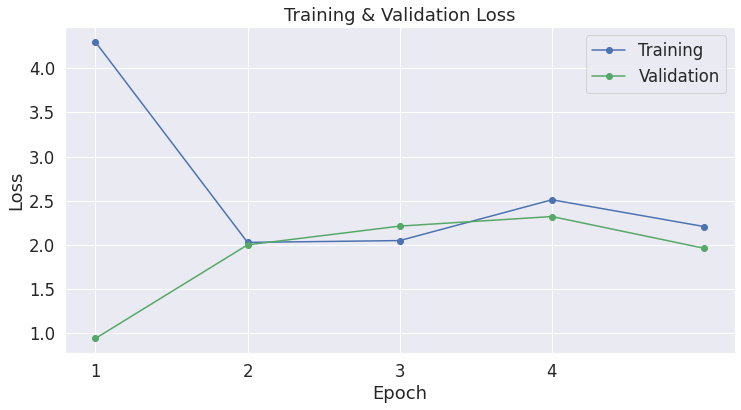

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

plt.show()

##🌌 Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(poem_model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

##  Saving & Loading Fine-Tuned Model


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = home_directory +'/model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = poem_model.module if hasattr(poem_model, 'module') else poem_model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

In [ ]:
home_directory+'/model_save/'

In [ ]:
!ls -l --block-size=K /content/drive/MyDrive/proyecto_NLP/models/model_save/

In [ ]:
!ls -l --block-size=M /content/drive/MyDrive/proyecto_NLP/models/model_save/pytorch_model.bin

In [ ]:
# Copy the model files to a directory in your Google Drive.
#!cp -r /content/drive/MyDrive/proyecto_NLP/models/model_save/  $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

cp: missing destination file operand after '/content/drive/MyDrive/proyecto_NLP/models/model_save/'
Try 'cp --help' for more information.


##Poems Generation

In [ ]:
poem_model.eval()

prompt = 'love is ridiculous'

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = poem_model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = MAX_LEN,
                                top_p=0.95, 
                                num_return_sequences=3,
                                num_beams=5, no_repeat_ngram_size=2, early_stopping=True
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))